# **Black-box Models**

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./filtered_df.csv')

In [16]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()

# Apply one-hot encoding to the categorical columns
for i in categorical_columns:
    one_hot_encoded = encoder.fit_transform(df[i])
    df[i]= one_hot_encoded

## **Black-box Model** : Random Forest Regressor

Mean Squared Error: 6541183183.57
R^2 Score: 0.78


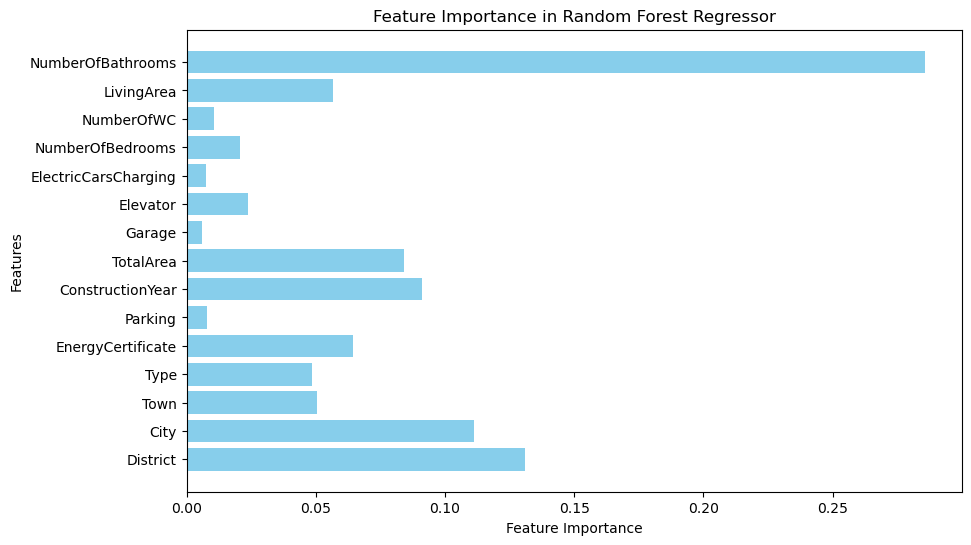

In [34]:
X = df.drop(["Price"],axis=1)
y = df['Price']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature Importance Visualization
importances = rf.feature_importances_
feature_names = X.columns

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

Task 3.1
Global Surrogates

Mean Squared Error: 9441075429.458601
R^2 Score: 0.5457492684298053


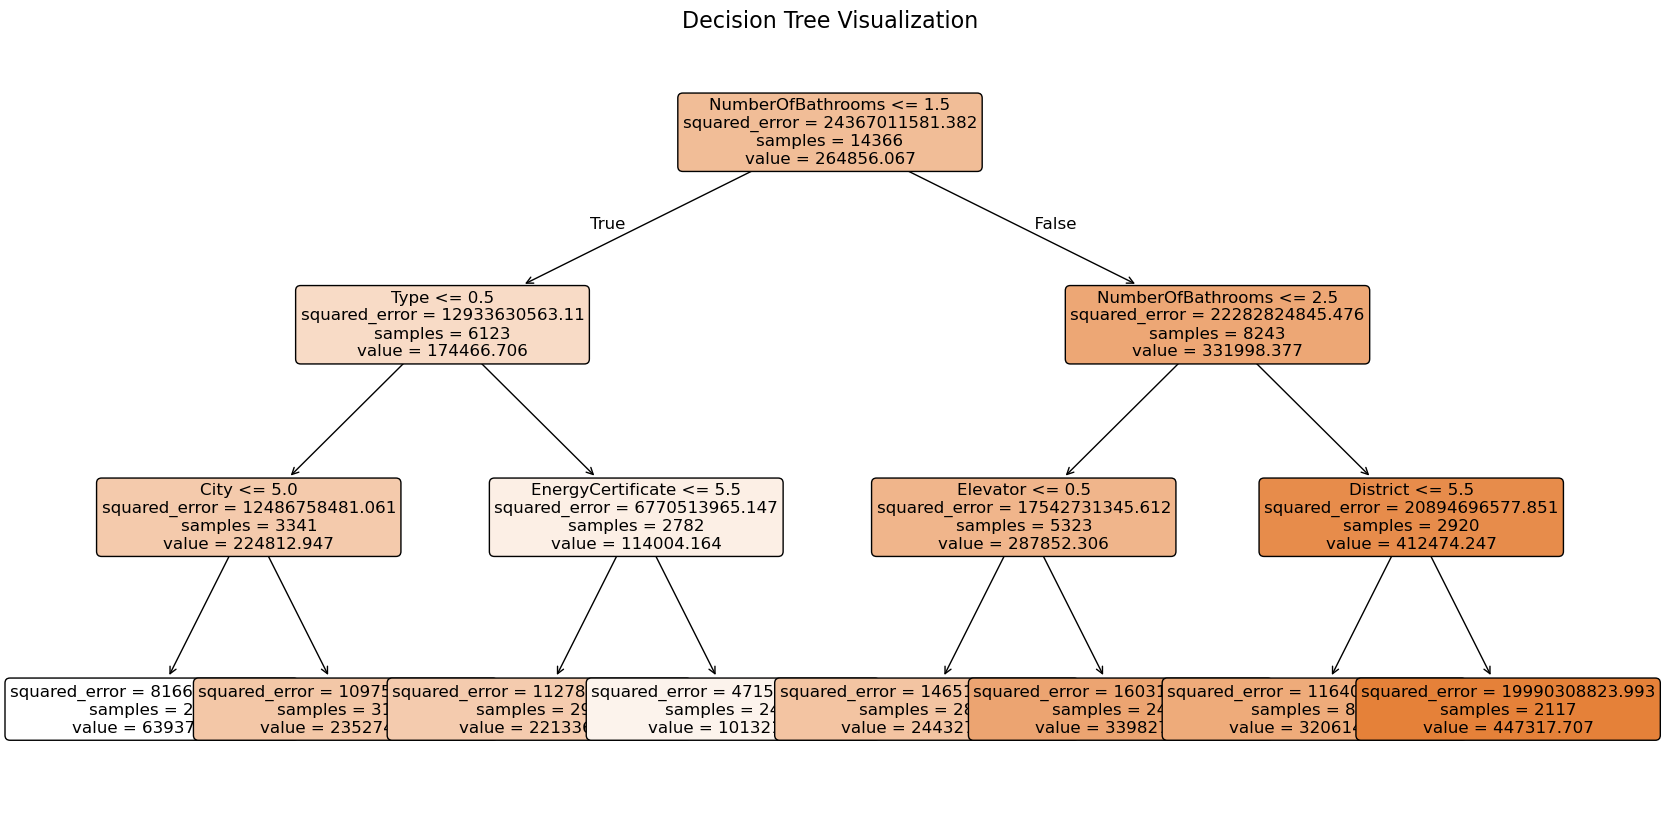

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
y_pre = rf.predict(X)
X_trai, X_tes, y_trai, y_tes = train_test_split(X, y_pre, test_size=0.3, random_state=42)
# Instantiate the Linear Regression model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)  # Adjust max_depth as needed

# Fit the model to the training data
dt_regressor.fit(X_trai, y_trai)

# Make predictions
y_pr = dt_regressor.predict(X_tes)

# Evaluate the model
mse = mean_squared_error(y_tes, y_pr)
r2 = r2_score(y_tes, y_pr)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

Task 3.2
Permutation Feature Importance

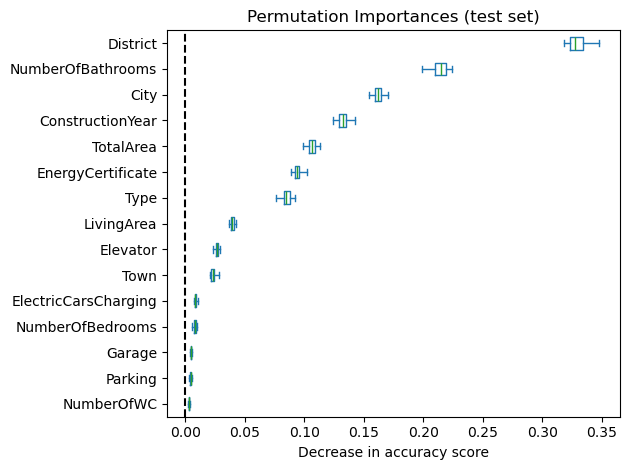

In [41]:
from sklearn.inspection import permutation_importance
import numpy as np
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=30, random_state=42, scoring='r2'
)
sorted_idx = perm_importance.importances_mean.argsort()

importances = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=X.columns[sorted_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


2 black box model


In [13]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200,300],        # Number of trees in the forest
    'max_depth': [5, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Setting up the GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimization metric
    n_jobs=-1,  # Use all available cores
    verbose=2  # Output progress
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Metrics for the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Mean Squared Error:", mse)
print("Best Model R2 Score:", r2)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

## **Black-box Model** : Neural Network Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Improved Feedforward Neural Network Model
model = Sequential([
    # First dense layer with 128 units and ReLU activation
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Second dense layer with 64 units and ReLU activation
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Third dense layer with 32 units and ReLU activation
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Fully connected layer to combine features
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # Output layer: predicting house price (regression task)
    Dense(1)  # No activation function here for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Epoch 1/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 97601814528.0000 - val_loss: 98863415296.0000
Epoch 2/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 97441841152.0000 - val_loss: 98598182912.0000
Epoch 3/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 95294758912.0000 - val_loss: 97359921152.0000
Epoch 4/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 92485615616.0000 - val_loss: 98097831936.0000
Epoch 5/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 89583656960.0000 - val_loss: 88926339072.0000
Epoch 6/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 83207929856.0000 - val_loss: 69395832832.0000
Epoch 7/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 73322725376.0000 - val_loss: 79101140992.0000
Epoch 8/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 68198547456.0000 - val_loss: 64527695872.0000
Epoch 9/150
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58359291904.0000 - val_loss: 36268732416.0000
Epoch 10/150
449/449 ━━━━━━━━━━━━━━━━